In [6]:
#Inital Imports
import numpy as np
import networkx as nx
import pandas as pd
import gurobipy as gb
from gurobipy import GRB

ModuleNotFoundError: No module named 'numpy'

## Step 1: Parse Network Topology and load Demands

In [16]:
# load data fram using pandas for topology
df = pd.read_csv("data/ATT/topology.txt", delimiter=r"\s+")

# Create Graph

G = nx.from_pandas_edgelist(df, 'from_node', 'to_node', ['capacity', 'prob_failure'])

## Step 2: Visualize Graph

{(2, 9): Text(-0.022644649442279445, 0.12927503926652825, '1200000'),
 (2, 3): Text(-0.06396540478300605, 0.33229158214388393, '1200000'),
 (2, 6): Text(-0.21612398214241585, 0.4682688399618725, '1200000'),
 (2, 17): Text(-0.07728572844829462, 0.14277484435012394, '1200000'),
 (2, 16): Text(0.03325242971551258, 0.13181231693166415, '1200000'),
 (2, 25): Text(-0.30185695843168003, 0.47663453965195646, '1200000'),
 (2, 21): Text(-0.19364946899916502, 0.04898760305152648, '1200000'),
 (2, 15): Text(-0.08596436762732428, 0.060119300226585945, '1200000'),
 (2, 20): Text(-0.03300290032274795, 0.3877046968304221, '1200000'),
 (9, 22): Text(0.03789479725711752, -0.23449092341622113, '1200000'),
 (9, 8): Text(0.17807834863439584, 0.07548515591390852, '1200000'),
 (9, 13): Text(0.17578202249439584, -0.13283523870798047, '1200000'),
 (9, 3): Text(0.05279284330067402, 0.1958574526957478, '1200000'),
 (9, 16): Text(0.15001067779919267, -0.004621812516471984, '1200000'),
 (9, 5): Text(0.005618939104

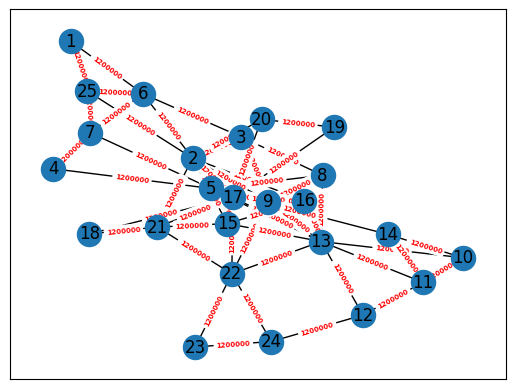

In [17]:
#Draw loaded graph
# spring layout prevents graph from
# becoming too clustered
layout = nx.spring_layout(G)
# draw node, edges, and labels sperately
nx.draw_networkx_labels(G, pos=layout)
nx.draw_networkx_nodes(G, pos=layout)
nx.draw_networkx_edges(G, pos=layout)
# only add capacities as labels
edge_labels = dict([((source, dest), G[source][dest]["capacity"]) for source, dest in G.edges])
nx.draw_networkx_edge_labels(G, pos=layout, edge_labels= edge_labels,font_color="red", font_weight="bold", font_size = 5)

In [91]:
## Get paths
## for each node, find paths to destination node
## paths[(i,j)] = list of paths specified by edges
paths = {}

num_paths = {}

n=25

for i in range(1,n+1):
    for j in range(1,n+1):
        path_gen = nx.all_simple_edge_paths(G, source=i, target=j, cutoff=5)
        p = list(path_gen)
        num_paths[(i,j)] = len(p)
        for k in range(len(p)):
            paths[(i,j,k)] = p[k]

print(paths[1,2,0])


[(1, 6), (6, 3), (3, 9), (9, 2)]


## Step 3: Parse Traffic Demands

In [123]:
demands = np.loadtxt("data/ATT/demand.txt")
## get the maximum value for each column
## reshape demands matrix
demands_matrix = np.amax(demands, axis = 0).reshape(25,25)

demands_dict = {}
for i in range(26):
    for j in range(26):
        demands_dict[(i,j)] = demands[i][j]

## Step 4: Traffic Algorithm: Maximize Total Throughput


In [73]:
#TODO
#Decision variables:

#edge current flows and capacities
flow_matrix = {}
capacity_matrix = {}
for key, value in edge_labels:
    flow_matrix[key] = 0
    capacity_matrix[key] = value



# edge_time, demand = demands_dict


#If flow is 0, edge is not active

#for each edge in edges: set in some array/matrix all the possible edges

#----------------------------

#Optimization function:

#Sum of the flows of all of the edges

model = gb.Model()

edges,capacities = edge_labels.keys(), edge_labels.values()

print(edges)

flow = model.addVars(edges, obj=capacities, name="flow")

model.setObjective(gb.quicksum(flow_matrix.values()), gb.GRB_MAXIMIZE)


#----------------------------

#Constraints: 

#Capacity check: Flow on edge (u, v) <= capacity (u, v)

#Demand reqs: flow into node u = demand u: f_in(u) - f_out(u) = demand(u) https://www.cs.cmu.edu/~ckingsf/bioinfo-lectures/flowext.pdf

#Conservation: Flow into node u = flow out of node u???

# model.addConstr(flow_matrix[(t, u, v)] <= capacity_matrix[t, u, v]])
# model.addConstr(flow_in[t, u] - flow_out[t, u])

dict_keys([(2, 9), (2, 3), (2, 6), (2, 17), (2, 16), (2, 25), (2, 21), (2, 15), (2, 20), (9, 22), (9, 8), (9, 13), (9, 3), (9, 16), (9, 5), (22, 13), (22, 17), (22, 23), (22, 24), (22, 21), (8, 13), (8, 3), (8, 5), (13, 5), (13, 11), (13, 17), (13, 12), (13, 16), (13, 10), (13, 15), (3, 6), (16, 17), (16, 15), (5, 7), (5, 4), (5, 14), (6, 1), (6, 25), (6, 7), (17, 19), (17, 18), (17, 21), (17, 15), (17, 20), (25, 1), (25, 7), (21, 18), (21, 15), (20, 19), (7, 4), (14, 11), (14, 10), (11, 12), (11, 10), (12, 24), (24, 23)])


AttributeError: module 'gurobipy' has no attribute 'GRB_MAXIMIZE'

In [132]:
# new model
m = gb.Model("step4")

# add a variable for each tunnel
path_vars = m.addVars(paths, name = "path_flow")

# dictionary mapping edges to variables representing paths edge is in
edge_flow = gb.tupledict([((source, dest), []) for source, dest in G.edges])


# iterate through all paths
for (i,j,k) in path_vars:
    path = paths[(i,j,k)]
    # iterate each edge in a path
    for src,dest in path:
        # add variable to correct edge
        if (src,dest) in edge_flow:
            edge_flow[(src,dest)].append(path_vars[i,j,k])
        else:
            edge_flow[(dest,src)].append(path_vars[i,j,k])

# add capacity constraint
for i,j in edge_flow:
    m.addConstr(sum(edge_flow[(i,j)]) <= edge_labels[(i,j)])

m.addConstrs(path_vars.sum(i,j,'*') <= demands[i][j] for i,j in demands_dict)

m.setObjective(path_vars.sum(), GRB.MAXIMIZE)

m.optimize()

path_vars

G_Prime = nx.DiGraph()

for path, val in path_vars:
    for i in range(len(path)):
        node_u = path[i]
        node_v = path[i+1]
        if G_Prime.has_edge(node_u, node_v):
            G_Prime[node_u][node_v]['weight'] += val
        else:
            G_Prime.add_edge(node_u, node_v, weight = val)
        
GPrime_labels = nx.get_edge_attributes(G_Prime, "weight")
nx.draw(G_Prime, arrows = True, with_labels = True)
position_labels = nx.spring_layout(G_Prime)
nx.draw_networkx_edge_labels(G_Prime, pos = position_labels, edge_labels = GPrime_labels)



Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 732 rows, 39386 columns and 221772 nonzeros
Model fingerprint: 0x72d79fa2
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+02, 1e+06]
Presolve removed 76 rows and 0 columns
Presolve time: 0.03s
Presolved: 656 rows, 39386 columns, 221772 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.250e+04
 Factor NZ  : 2.828e+04 (roughly 16 MB of memory)
 Factor Ops : 1.483e+06 (less than 1 second per iteration)
 Threads    : 8

Barrier performed 0 iterations in 0.05 seconds (0.07 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Iteration    Objecti

{(1, 2, 0): <gurobi.Var path_flow[1,2,0] (value 0.0)>,
 (1, 2, 1): <gurobi.Var path_flow[1,2,1] (value 0.0)>,
 (1, 2, 2): <gurobi.Var path_flow[1,2,2] (value 0.0)>,
 (1, 2, 3): <gurobi.Var path_flow[1,2,3] (value 0.0)>,
 (1, 2, 4): <gurobi.Var path_flow[1,2,4] (value 0.0)>,
 (1, 2, 5): <gurobi.Var path_flow[1,2,5] (value 0.0)>,
 (1, 2, 6): <gurobi.Var path_flow[1,2,6] (value 0.0)>,
 (1, 2, 7): <gurobi.Var path_flow[1,2,7] (value 0.0)>,
 (1, 2, 8): <gurobi.Var path_flow[1,2,8] (value 0.0)>,
 (1, 2, 9): <gurobi.Var path_flow[1,2,9] (value 0.0)>,
 (1, 2, 10): <gurobi.Var path_flow[1,2,10] (value 0.0)>,
 (1, 2, 11): <gurobi.Var path_flow[1,2,11] (value 14222.21402)>,
 (1, 2, 12): <gurobi.Var path_flow[1,2,12] (value 0.0)>,
 (1, 2, 13): <gurobi.Var path_flow[1,2,13] (value 0.0)>,
 (1, 2, 14): <gurobi.Var path_flow[1,2,14] (value 0.0)>,
 (1, 3, 0): <gurobi.Var path_flow[1,3,0] (value 0.0)>,
 (1, 3, 1): <gurobi.Var path_flow[1,3,1] (value 0.0)>,
 (1, 3, 2): <gurobi.Var path_flow[1,3,2] (value

In [ ]:
m = gb.Model("step4")

traffic = {}
for (i, j) in demands_matrix:
    if (i, j) in edge_labels:
        traffic[(i, j)] = m.addVar(ub=edge_labels[(i, j)], name=f"traffic_{i}_{j}")
    else:
        traffic[(i, j)] = m.addVar(ub=0, name=f"traffic_{i}_{j}")
m.addVars(paths)

#dict of edgevalue variables for each possible path between two nodes
edgevals = {}
#Add variables to each edge in the path: v1 + v2 + ... , make sure to constrain later to <= demand[node source, node sink]
for (i, j) in demands_matrix:
    edgevals[(i, j)] = m.addVar(ub=edge_labels[(i, j)], name=f"edgevals_{i}_{j}")

for (i, j) in demands_matrix:   
        
        
for (i, j) in demands_matrix:
    print((i, j))
    m.addConstr(gb.quicksum((traffic[(i, j)] - traffic[(j, i)]) for (i, j) in demands_matrix) == demands_matrix[(i , j)])
for (i, j) in edge_labels:
    m.addConstr(gb.quicksum((traffic[(i, j)]) for (i,j) in demands_matrix) <= edge_labels[(i, j)])

m.setObjective(gb.quicksum(traffic[(i, j)] for (i, j) in demands_matrix), GRB.MAXIMIZE)

m.optimize()

if m.status == GRB.OPTIMAL:
    print('Optimal traffic allocation')

## Step 5: Traffic Algorithm: Maximize Link Utilization

In [ ]:
#Same as step 4 on a new model
m_prime = gb.Model("step5")
path_vars5 = m.addVars(paths, name = "path_flow")
edge_flow5 = gb.tupledict([((source, dest), []) for source, dest in G.edges])

for (i,j,k) in path_vars5:
    path = paths[(i,j,k)]
    for src,dest in path:
        if (src,dest) in edge_flow5:
            edge_flow5[(src,dest)].append(path_vars5[i,j,k])
        else:
            edge_flow5[(dest,src)].append(path_vars5[i,j,k])

# add capacity constraint
for i,j in edge_flow5:
    m_prime.addConstr(sum(edge_flow5[(i,j)]) <= edge_labels[(i,j)])


#***new for step 5*** Need to add constraint that the maximum link value needs to be reduced 

for i,j in edge_flow5:
    #Percentage of load on a link
    #edge_ratio = sum(edge_flow5[(i,j)])/edge_labels[(i,j)]
    m_prime.setObjective(sum(edge_flow5[(i,j)])/edge_labels[(i,j)], GRB.MINIMIZE)

#having demand bounded like this will push all nodes to have "0" for flow, so we want to maximize the throughput as well (which is why we reuse step 4 constraints)

m_prime.addConstrs(path_vars5.sum(i,j,'*') <= demands[i][j] for i,j in demands_dict)

m_prime.setObjective(path_vars5.sum(), GRB.MAXIMIZE)

m_prime.optimize()

path_vars5

#Alternative written of step 4 visualization using edge_flows:
G_Prime2 = nx.DiGraph()

for i,j in edge_flow5:
    G_Prime2.add_edge(i, j, weight = sum(edge_flow5[i,j]))

GPrime2_labels = nx.get_edge_attributes(G_Prime2, "weight")
nx.draw(G_Prime2, arrows = True, with_labels = True)
position_labels = nx.spring_layout(G_Prime2)
nx.draw_networkx_edge_labels(G_Prime2, pos = position_labels, edge_labels = GPrime2_labels)


## Step 6: Compare Algorithms

TODO

## Step 7 (EXTRA CREDIT): Scaling with Topology Size